# Linear Kalman Filter Implementation Test
## Initializing a Kalman Filter Object
The following sets up an instance of `KalmanFilter` which represents a tracked object which would become an entry in the main hash map for the final implementation. The parameters for now are set up such that the estimated state vector $\vec{x} \, \epsilon \, \mathbb{R}^{4}$, where $\vec{x} = \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y} \\ \ddot{x} \end{bmatrix}$ so the corresponding state transition matrix $F \, \epsilon \, \mathbb{R}^{4 \times 4}$, the state covariance matrix $P \, \epsilon \, \mathbb{R}^{4 \times 4}$, the measurement matrix $H\,\epsilon\,\mathbb{R}^{4\times4}=I_4$ since the measurement space is the same as the estimated state space, and the model/process error $Q\,\epsilon\,\mathbb{R}^{4\times4}$ is generated with the `Q_discrete_white_noise` function provided by `filterpy` but I don't completely understand how it works.

In [36]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import numpy as np

# constant
dt = 1/50 # the radar refreshes at 50Hz

obj = KalmanFilter(dim_x=4, dim_z=4)
obj.H = np.identity(4)
obj.F = np.array([[1,0,dt,0],
                  [0,1,0,dt], 
                  [0,0,1,0], 
                  [0,0,0,1]])

# initial state
obj.x = np.array([0,0,2,1])
np.fill_diagonal(obj.P, [100 for _ in range(4)])
obj.Q = Q_discrete_white_noise(2, dt, .5**2, block_size=2)

# the measurement error is going to be constant for now
np.fill_diagonal(obj.R, [.25**2 for _ in range(4)])

In [37]:
Q_discrete_white_noise(2, dt, .1**2, block_size=2)

array([[4.e-10, 4.e-08, 0.e+00, 0.e+00],
       [4.e-08, 4.e-06, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 4.e-10, 4.e-08],
       [0.e+00, 0.e+00, 4.e-08, 4.e-06]])

In [38]:
obj.Q

array([[1.e-08, 1.e-06, 0.e+00, 0.e+00],
       [1.e-06, 1.e-04, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e-08, 1.e-06],
       [0.e+00, 0.e+00, 1.e-06, 1.e-04]])

## Making Test Data
At first I need to know if this works at all on some positively correlated data so the following will construct a fake set of data where the object keeps travelling in the positive logitudinal direction at 1 m/s and positive lateral direction at 2 m/s and all measurements exhibit the same standard deviation to simulate a sensor that returns a monomodal Gaussian Distribution. Since the standard deviation is fixed for the whole data set, I also made $R$ a constant diagonal matrix whose diagonal is filled with the variance of each variable in the measurement vector which is that same standard deviation squared.

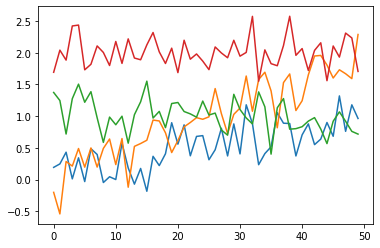

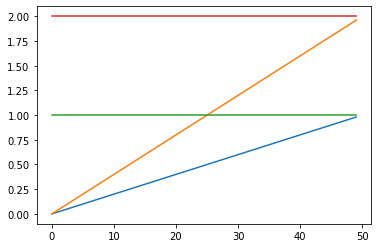

In [39]:
import matplotlib.pyplot as plt
from numpy.random import randn

test_y = []
ground_truth = []
std_dev = .25
for i in range(50):
    test_y.append(np.array([randn()*std_dev+i*dt, 
                            randn()*std_dev+i*dt*2, 
                            randn()*std_dev+1, 
                            randn()*std_dev+2]))
    
    ground_truth.append(np.array([i*dt, i*dt*2, 1, 2]))
    
test_y = np.asarray(test_y)
ground_truth = np.asarray(ground_truth)

plt.plot(test_y)
plt.show()
plt.plot(ground_truth)
plt.show()

Now I will see how the filter performs

In [40]:
filtered_y = [] # to track history
for i in range(50):
    obj.predict()
    obj.update(test_y[i])
    filtered_y.append(obj.x)
filtered_y = np.asarray(filtered_y)
x = np.arange(0,1,1/50)

## Visualizing Filter Output
I plotted how each variable in the state estimation vector in the same order as the initialization changes over time bellow. Shown in red is the noising input signal, in blue the filter output, and in green the ground truth or the mean of the noisy input.

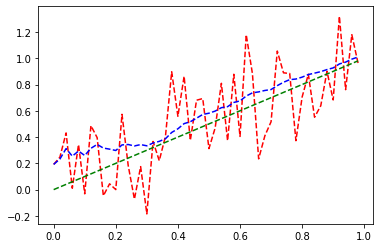

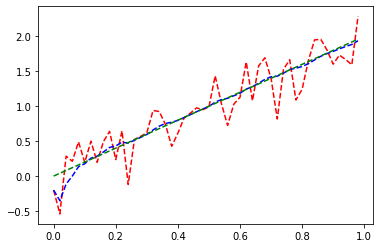

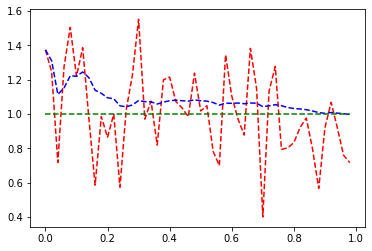

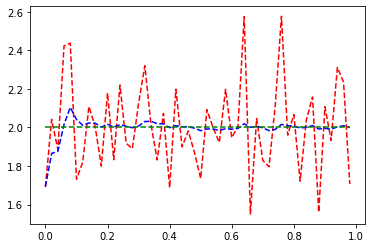

In [41]:
for i in range(4):
    plt.plot(x, test_y[:,i], 'r--', x, filtered_y[:,i], 'b--', x, ground_truth[:,i], 'g--')
    plt.show()

## Unresolved Issue
As you can see in the last graph and the final $P$ output bellow, for some reason $\dot{y}$ stays noisy and exhibit a larger variance than the other three.

In [42]:
obj.P

array([[ 1.52715460e-03,  1.20060549e-05,  5.65401058e-04,
        -8.89101300e-09],
       [ 1.20060549e-05,  2.72764003e-03, -8.89101300e-09,
         5.64512046e-04],
       [ 5.65401058e-04, -8.89101300e-09,  1.15399754e-03,
         1.32661221e-05],
       [-8.89101300e-09,  5.64512046e-04,  1.32661221e-05,
         2.48047709e-03]])